In [1]:
# Linear algebra, data processing 
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Data Visualization:
import matplotlib.pyplot as plt
import openslide # special lib for pathology images

# Data Augmentation:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Creating Model: Transfer Learning w/ Keras Dataset:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, BatchNormalization, Activation, GlobalMaxPooling2D
from keras.models import Sequential, Model

# Trainig Model:
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import cohen_kappa_score

# Other Libs:
from IPython.display import clear_output
import os

# Importing the Datasets

#### Let's first look at the competition dataset:

In [2]:
comp_train_images = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
comp_train_images.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [3]:
comp_train_images.shape

(10616, 4)

We see that we have 10,616 biposy images with varying sizes.

# Data Visualization

#### Let's now take a look at one of the biopsies:

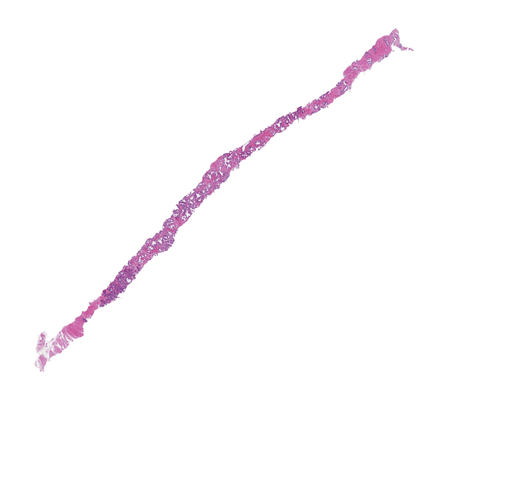

In [4]:
img = openslide.OpenSlide('../input/prostate-cancer-grade-assessment/train_images/004391d48d58b18156f811087cd38abf.tiff')
display(img.get_thumbnail(size=(512,512)))

In [5]:
img.dimensions

(31872, 30114)

We see that these biopsy images are quite large, therefore I will be using the resized 512x512 dataset that can be found here: https://www.kaggle.com/xhlulu/panda-resized-train-data-512x512

#### Let's take a look at the class distribution for the ISUP Grade:

In [6]:
comp_train_images['isup_grade'].value_counts()

0    2892
1    2666
2    1343
4    1249
3    1242
5    1224
Name: isup_grade, dtype: int64

We see that grade 0 which is non-cancerous is over-emphasized while severe cases such as grade 5 is under-represented! We may need to use data augmentation to increase the number of images.

# Data Preparation

#### Let's first create two lists to store the images and their respective ISUP Grade:

In [7]:
labels = []
data = []

# 
res_train_images = '../input/panda-resized-train-data-512x512/train_images/train_images/'
for i in range(comp_train_images.shape[0]):
    data.append(res_train_images+comp_train_images['image_id'].iloc[i]+'.png')
    labels.append(comp_train_images['isup_grade'].iloc[i])

# Create dataframe object to feed to our model:
df = pd.DataFrame(data)
df.columns = ['images']
df['isup_grade'] = labels

In [8]:
df['isup_grade'].dtypes # Check data type of isup_grade column

dtype('int64')

We see that the labels are integers.

In [9]:
print(labels[0:3], data[0:3]) # print the first 3 image IDs and their respective ISUP Grades

[0, 0, 4] ['../input/panda-resized-train-data-512x512/train_images/train_images/0005f7aaab2800f6170c399693a96917.png', '../input/panda-resized-train-data-512x512/train_images/train_images/000920ad0b612851f8e01bcc880d9b3d.png', '../input/panda-resized-train-data-512x512/train_images/train_images/0018ae58b01bdadc8e347995b69f99aa.png']


Here we see that the first and second image is of ISUP grade 0 (non-cancerous), while the third image is of ISUP grade 4 which is cancerous.

#### Now let's split the dataset for training:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['images'],df['isup_grade'], test_size=0.225, random_state=42)

We split the data for training and testing. We allocate 22.5% of the data for testing and does a shuffle of the data 

In [11]:
print(X_train[0:5], y_train[0:5])

3465     ../input/panda-resized-train-data-512x512/trai...
4605     ../input/panda-resized-train-data-512x512/trai...
8480     ../input/panda-resized-train-data-512x512/trai...
10387    ../input/panda-resized-train-data-512x512/trai...
1328     ../input/panda-resized-train-data-512x512/trai...
Name: images, dtype: object 3465     0
4605     2
8480     1
10387    0
1328     1
Name: isup_grade, dtype: int64


In [12]:
train = pd.DataFrame(X_train)
train.columns = ['images']
train['isup_grade'] = y_train

valid = pd.DataFrame(X_test)
valid.columns = ['images']
valid['isup_grade'] = y_test

train['isup_grade'] = train['isup_grade'].astype(str)
valid['isup_grade'] = valid['isup_grade'].astype(str)

# print(train['isup_grade'].dtypes)

## Data Augmentation and Pre-processing

The following are the **augmentaion** done: 
* Rotation 
* Shifting Image (Up/Down/Left/Right)
* Cutting Image
* Zooming 
* Horizontal Flipping

The following are the **pre-processing** done: 
* Resizing Images (from 512,512,3 to 244,244,3)
* Normalizing (0-1)

In [13]:
# create data generator objects that transforms training and validation images:
datagen = ImageDataGenerator(rescale=1./255., rotation_range=40, width_shift_range=0.2, 
                height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, 
                horizontal_flip=True, fill_mode='nearest') 

train_gen = datagen.flow_from_dataframe(train,
                    x_col='images',
                    y_col='isup_grade',
                    target_size=(224, 224),
                    batch_size=32,
                    class_mode='categorical')

valid_gen = datagen.flow_from_dataframe(
    valid,
    x_col='images',
    y_col='isup_grade',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 8227 validated image filenames belonging to 6 classes.
Found 2389 validated image filenames belonging to 6 classes.


Note: We use 224,224,3 because VGG16 uses the same shape!

#### Before we go any further, let's visualize our data once more:

In [31]:
def show_tiles(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(10):
        ax = plt.subplot(1,10,n+1)
        plt.imshow(image_batch[n])
        decoded = np.argmax(label_batch[n])
        plt.title(decoded)
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_gen))

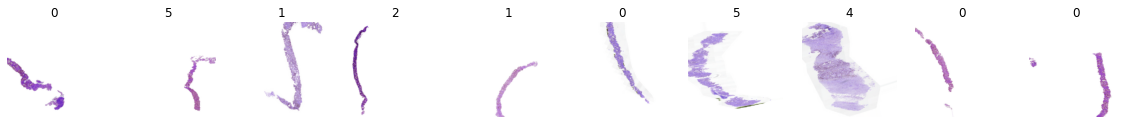

In [32]:
show_tiles(image_batch, label_batch)

A view of cell biopsies and their ISUP grades.

# Creating the Model

Use VGG16 for transfer learning, and remove the output layer as we only have 6 outputs:

In [14]:
def vgg_model(num_classes=None):
    vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    x = Flatten()(vgg.output)
    output = Dense(num_classes,activation='softmax')(x)
    model = Model(vgg.input,output)
    return vgg

base_model = vgg_model(6)

58892288/58889256 [==============================] - 1s 0us/step


In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We've sucessfully frozen the base, therefore we won't be able to make any changes to the weights of any layers that are frozen during training.

#### Now let's add our classifier, add the prediction layer and combine the layers together in a model:

In [33]:
model = tf.keras.Sequential([
  base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(6, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                8208      
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 14,723,062
Trainable params: 8,342
Non-trainable params: 14,714,720
_________________________________________________________________


We see we have 8,342 trainable params!

# Training the Model

In [36]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=tf.keras.metrics.AUC(name='auc'))

#### Let's utilize multiple callbacks, to make sure that we are using an ideal learning rate and to prevent the model from overfitting. 

In [37]:
base_learning_rate = 0.01 # Learning rate that it too high will prevent the model from converging, one that is too low will be far too slow.
nb_epochs = 20
batch_size = 32
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=valid.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 257 and 74


In [38]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(base_learning_rate, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("prostate_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

We also saved our model so that we do not have to retrain it next time.

In [39]:
history = model.fit(
    train_gen,
    steps_per_epoch=nb_train_steps,
    epochs=nb_epochs,
    validation_data=valid_gen,
    validation_steps=nb_val_steps,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler])

Epoch 1/20
257/257 [==============================] - 1161s 4s/step - loss: 1.6314 - auc: 0.6913 - val_loss: 1.5839 - val_auc: 0.7187
Epoch 2/20
257/257 [==============================] - 1138s 4s/step - loss: 1.5498 - auc: 0.7329 - val_loss: 1.7384 - val_auc: 0.6419
Epoch 3/20
257/257 [==============================] - 1138s 4s/step - loss: 1.5491 - auc: 0.7325 - val_loss: 1.7249 - val_auc: 0.6301
Epoch 4/20
257/257 [==============================] - 1138s 4s/step - loss: 1.5389 - auc: 0.7379 - val_loss: 1.5677 - val_auc: 0.7238
Epoch 5/20
257/257 [==============================] - 1138s 4s/step - loss: 1.5305 - auc: 0.7418 - val_loss: 1.6099 - val_auc: 0.7046
Epoch 6/20
257/257 [==============================] - 1138s 4s/step - loss: 1.5476 - auc: 0.7335 - val_loss: 1.5481 - val_auc: 0.7359
Epoch 7/20
257/257 [==============================] - 1138s 4s/step - loss: 1.5231 - auc: 0.7449 - val_loss: 1.5678 - val_auc: 0.7286
Epoch 8/20
257/257 [==============================] - 1138s 4s